<h1 style="color: green;">Explaining the regressor model with SHAP values</h1>
<p>
Traditional methods of assessing the performance of a regressor model such as R-squared, MSE, RMSE and MAE<br>
don't detail the construction of the prediction. This makes it difficult to trust model output if it cannot be understood.<br>A trust worthy model has local and global fidelity:
<ul>
<li><b>Global fidelity:</b> An explaination of the positive and negative relationship between the features and the target from a wholistic model point of view</li>

<li><b>Local fidelity:</b> An explaination of how the model behaves for a single prediction i.e. the feature by feature contribution to the prediction</li>
</ul>
Local fidelity does not imply global fidelity: features that are globally important may not be important for a<br> single prediction and vice versa i.e. a single prediction is driven by the data available for that instance<br>
and the magnitude of each feature will vary such that less powerful features could end up contributing more to<br> a single prediction than more powerful features. This will be clarified below.<br><br>
<b>Note, the data used is standardized data that was first encoded with ordered ordinal encoder.</b><br>
Thus, the absolute values are not in meaningful units but they show the relationships with the prediction.
</p>

<h1 style="color: green;">Import libraries</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import joblib

# from tqdm.notebook import tqdm
import shap

import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


<h1 style="color: green;">Load the data from the final model</h1>

In [2]:
X_train = pd.read_csv("../2. Data/Regressor_X_train_final.csv")
X_test = pd.read_csv("../2. Data/Regressor_X_test_final.csv")

In [3]:

X_train.head()

,Drinks_wk,Fruit_wk,Tech_and_services_wk,Snacks_wk,Vegetables_wk,Bread_wk,Raw_meats_wk,Breakfast_wk,Nbr_items_per_wk,Cooking_base_wk,Transport_wk,Cosmetics_and_selfcare_wk,Electronics_wk,Education_wk,Total_Exp_wk_perc,Total_Price,Nbr_trips_per_wk
0,-0.801605,-0.636884,1.60002,-0.871993,0.955473,-0.654710,-1.161686,-0.212712,-0.784424,0.209359,-0.163119,-0.038553,2.155373,-0.28943,-2.040103,0.184136,-0.479869
1,-0.801605,1.206962,-0.50064,-0.314313,0.955473,0.236902,0.953877,-0.212712,-1.593605,0.209359,-0.163119,-0.038553,-0.309612,-0.28943,-0.194649,1.196071,-0.479869
2,-0.801605,-0.636884,-0.50064,-0.871993,-0.516856,0.236902,0.953877,-0.212712,-1.593605,0.209359,-0.163119,-0.038553,-0.309612,-0.28943,-2.040103,0.184136,-1.416972
3,1.391332,-0.636884,-0.50064,0.243368,0.955473,0.236902,-1.161686,-0.212712,-1.593605,0.209359,-0.163119,-0.038553,-0.309612,-0.28943,-2.040103,-0.827799,-0.479869
4,-0.070626,-0.636884,-0.50064,-0.871993,-1.253021,1.128514,-0.103905,-0.212712,0.024758,0.209359,-0.163119,2.355608,-0.309612,-0.28943,-1.117376,0.184136,-0.479869


In [4]:
X_test.head()

,Drinks_wk,Fruit_wk,Tech_and_services_wk,Snacks_wk,Vegetables_wk,Bread_wk,Raw_meats_wk,Breakfast_wk,Nbr_items_per_wk,Cooking_base_wk,Transport_wk,Cosmetics_and_selfcare_wk,Electronics_wk,Education_wk,Total_Exp_wk_perc,Total_Price,Nbr_trips_per_wk
0,-0.801605,-0.636884,-0.50064,0.243368,-0.516856,1.128514,-1.161686,-0.212712,0.024758,0.209359,-0.163119,-0.038553,-0.309612,-0.28943,0.728078,-0.827799,1.394336
1,1.391332,1.206962,-0.50064,-0.871993,0.219308,1.128514,-0.103905,-0.212712,-0.784424,-1.547558,-0.163119,-1.235634,-0.309612,-0.28943,0.728078,0.184136,0.457234
2,1.391332,-0.636884,-0.50064,-0.871993,-1.253021,1.128514,-0.103905,-0.212712,0.833939,-1.547558,-0.163119,-0.038553,-0.309612,-0.28943,0.728078,-0.827799,-0.479869
3,0.660353,1.206962,-0.50064,-0.314313,-1.253021,1.128514,2.011659,-0.212712,0.833939,0.209359,-0.163119,-0.038553,-0.309612,-0.28943,0.728078,-0.827799,-0.479869
4,-0.801605,1.206962,-0.50064,1.916409,-0.516856,-0.654710,-1.161686,-0.212712,-1.593605,0.209359,-0.163119,-0.038553,-0.309612,-0.28943,0.728078,1.196071,-0.479869


<h1 style="color: green;">Load the model</h1>

In [7]:
GBR = joblib.load("../8. Models/Regressor_models/GBRegressor_19082023")

<h1 style="color: green;">Load the y scaler</h1>

In [8]:
y_scaler =  joblib.load("../8. Models/StandardScaler_models/y_scaler26072023")

<h3 style="color: green;">Building the explainer</h3>

In [9]:
explainer =  shap.TreeExplainer(GBR)

<h1 style="color: green;">Global fidelity</h1>
<p>
Below the focus is on the model as a whole: to generate insight with respect to<br>
the positive and negative relationship between the predictors and the target.
</p>

<h3 style="color: green;">X_train global fidelity</h3>

In [10]:
# Generating shap values
X_train_shap_values = explainer.shap_values(X_train)

In [11]:
# Preparing the colours
colors = ["#000000", "#AEEA00", "#DD2C00"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

<h3 style="color: green;">X_test global fidelity</h3>

In [12]:
# This predicts the test Expenditure_per_week and returns corresponding shap values
X_test_shap_values = explainer.shap_values(X_test)

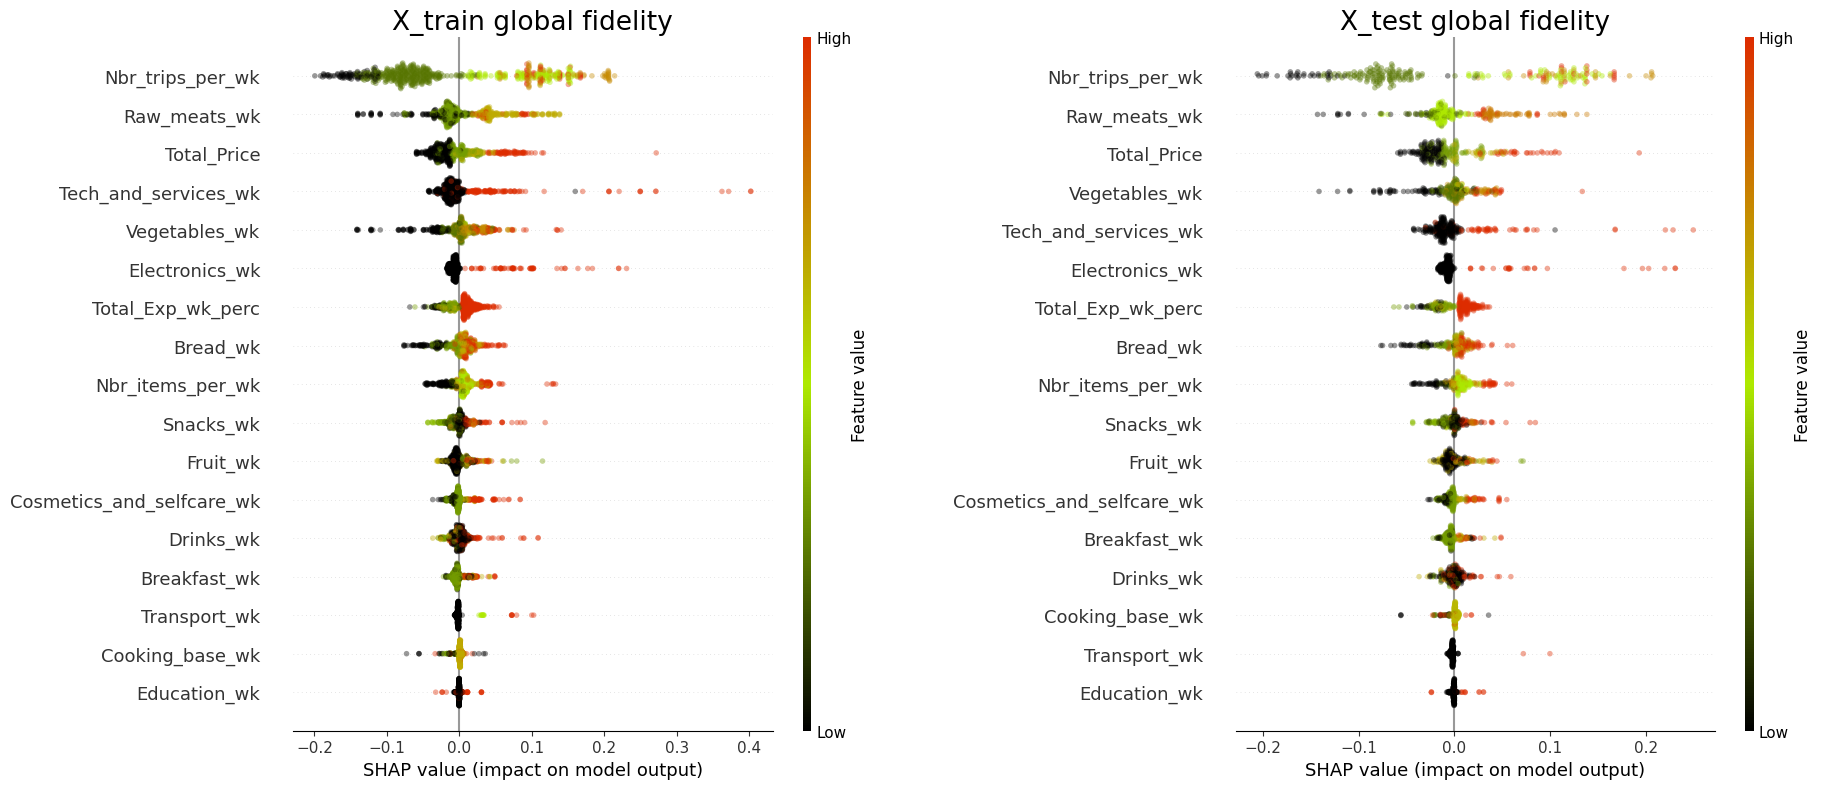

In [13]:
fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.summary_plot(X_train_shap_values, X_train, cmap=cmap, alpha=0.4, show=False)
plt.title("X_train global fidelity", fontsize=19)
ax1 = fig.add_subplot(122)
shap.summary_plot(X_test_shap_values, X_test, cmap=cmap, alpha=0.4, show=False)
plt.title("X_test global fidelity", fontsize=19)

plt.gcf().set_size_inches(19,8)
plt.tight_layout()
plt.show()

<p>
The plots above show features ranked in descending order of feature importance.<br><br>
<b style="color: green;">How to read the plots</b>
<ul>
<li>Each dot represents a respective value for that feature</li>
<li>The colour of the dot represents the magnitude of the value. This is mapped to the colour bar on the right of each plot.</li>
<li><b>Effect:</b> The horizontal location, x-axis, shows whether the effect of that value is associated with a higher or lower shap value, prediction</li>
<li><b>Correlations:</b> for a given feature red dots to the right of 0 and black dots to the left of 0 indicates a positive correlation while the reverse indicates a negative correlation.</li>
</ul>
<b style="color: green;">Interpreting the plots</b><br>
There is a lot of insight coming out these plots:
<ul>

<li>Mostly the ranking is preserved between X_train and X_test  with the exception of the following features swapping positions: Tech_and_services_wk with Vegetables_wk; Drinks_wk with Breakfast_wk; Transport_wk with Cooking_base_wk.<br><br></li>    
    
<li>The distribution pattern of the dots across both train and test plots are approximately the same this illustrates that there is no data drift, the underlying data distributions are the same, and since the plot illustrates the relationship with the prediction, there is also no concept drift from training to testing.<br><br></li>    

<li>Looking at Nbr_trips_per_wk in both plots it's clear that lower number of trips has a clear linear negative relationship with the prediction, expenditure per week, the black dots are to the far left and followed by the darker greens closer to zero, no mixture of colours i.e. the darker the color the more negative the effect on the prediction.<br>

However moderate to higher number of trips have a non-linear positive relationship with the prediction; the light greens are mixed in with the reds creating a non-linear/weak positive relationship with the prediction i.e. there is no clear distinction between the positive effect of light greens and reds on the prediction. This may indicate possible interaction with other features.<br></li>

<li>Looking at Raw_meats_wk, the range is narrower than the Nbr_trips_per_wk range meaning the predictions are relatively less sensitive to values of Raw_meats_wk than they are to values of Nbr_trips_per_wk; Although there is a positive correlation, in the training plot the negative relationship is unclear, the darker green dots and the black dots are mixed in a cluster close to 0.<br><br>
</li>
<li>Tech_and_services_wk and Electronics_wk have very good positive relationships with the predictions: low values of both have a negative relationship with the predictions; the values cluster around 0 which means the predictions are less sensitive to low values of either feature.<br><br>The predictions are highly sensitive to high values of either feature: high values of either feature have a positive relationship to the predictions, however there is no moderate values to see if there is a gradual change.<br><br></li>
<li>The rest of the feature relationships to the predictions can be explained in similar fashions as above.</li>
</ul>
</p>

<h1 style="color: green;">Local fidelity</h1>
<p>
Below the the focus is on individual observations: The objective is to illustrate how feature values contribute <br>to the prediction value, positively or negatively. This is a very effective way to visualize the building<br>
blocks of the model output i.e. how the constituent features shape the prediction value.
</p>

<h3 style="color: green;">Local fidelity for observation 10</h3>

In [14]:
test_shap_10 = pd.Series(X_test_shap_values[10,:], index=X_test.iloc[10,:].index)
test_shap_10

Drinks_wk                   -0.000331
Fruit_wk                    -0.009321
Tech_and_services_wk        -0.009049
Snacks_wk                    0.013489
Vegetables_wk               -0.006023
Bread_wk                     0.008071
Raw_meats_wk                -0.004333
Breakfast_wk                -0.001477
Nbr_items_per_wk             0.003342
Cooking_base_wk              0.000951
Transport_wk                -0.002055
Cosmetics_and_selfcare_wk   -0.001457
Electronics_wk              -0.004323
Education_wk                -0.000231
Total_Exp_wk_perc           -0.007780
Total_Price                 -0.025045
Nbr_trips_per_wk            -0.128839
dtype: float64

<h3 style="color: green;">Calculating the prediction shap value for observation 10</h3>
<b>The prediction shap value is an additive summary of all the individual feature shap values for the instance in question plus the explainer.expected_value, the null model i.e. the intercep if it were a linear regression.</b>

In [18]:
prediction_shap_10 = test_shap_10.sum() + explainer.expected_value
prediction_shap_10[0]

-0.31922493880148495

<h3 style="color: green;">Plotting local fidelity for observation 10</h3>

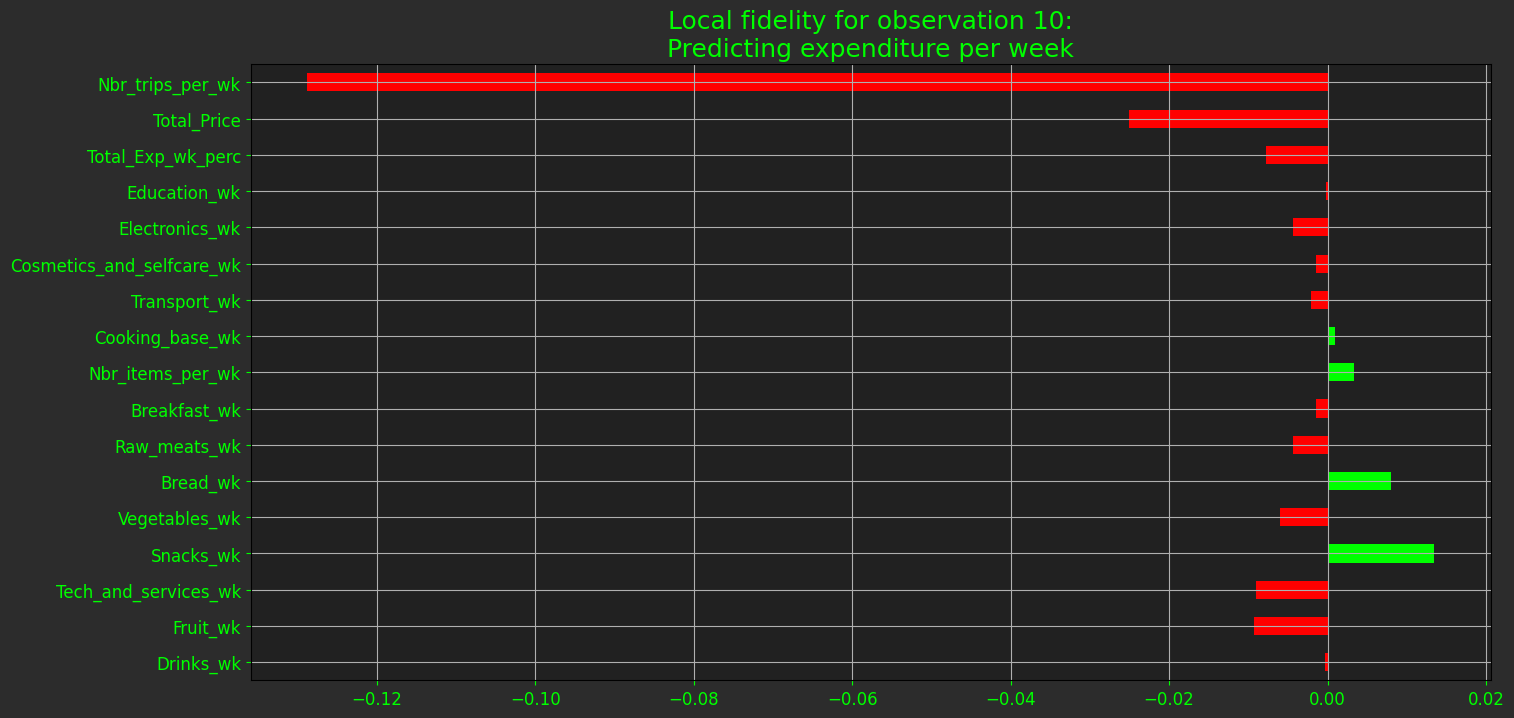

In [19]:
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

pos_val = test_shap_10 > 0

test_shap_10.plot(ax=ax,
                kind='barh',
                color= pos_val.map({True:'lime', False: 'red'}),
                fontsize=12
               )
plt.grid()
plt.title('Local fidelity for observation 10:\nPredicting expenditure per week', fontsize=18)
plt.show()

<p>
The chart above shows the extent of the contribution each feature makes to the estimation of prediction_shap_10.<br>For this instance it can be seen that Nbr_trips_per_wk had a large negative effect on the prediction. Note the<br> majority of features have a negative effect on the prediction for this instance. This would result in a smaller <br>prediction for expenditure per week. Below the model is used to predict test10_data then inverse transformed<br>to see the actual predicted expenditure.
</p>

In [21]:
test10_data = X_test.loc[10:10,:]

# predicting Expenditure per week with the sample above
test_10_pred = GBR.predict(test10_data)


actual_10_pred = y_scaler.inverse_transform(test_10_pred.reshape(-1,1))

print(f"Standardized output: {test_10_pred[0]} \nInverse transformed output: {actual_10_pred[0][0]}")

Standardized output: -0.31922493880147856 
Inverse transformed output: 39.64258999062068


<p>The inverse transform of the prediction is £39.64. This will be compared to the output for other observations to confirm the local fidelity.</p>

<h3 style="color: green;">Local fidelity for observation 88</h3>

In [22]:
test_shap_88 = pd.Series(X_test_shap_values[88,:], index=X_test.iloc[88,:].index)
test_shap_88

Drinks_wk                   -0.003029
Fruit_wk                    -0.001069
Tech_and_services_wk        -0.003199
Snacks_wk                    0.003495
Vegetables_wk                0.007168
Bread_wk                     0.000356
Raw_meats_wk                -0.017268
Breakfast_wk                -0.005732
Nbr_items_per_wk             0.037282
Cooking_base_wk              0.001613
Transport_wk                -0.003386
Cosmetics_and_selfcare_wk    0.021939
Electronics_wk              -0.007000
Education_wk                -0.000548
Total_Exp_wk_perc            0.005508
Total_Price                 -0.016621
Nbr_trips_per_wk             0.111957
dtype: float64

<h3 style="color: green;">Calculating the prediction shap value for observation 88</h3>

In [23]:
prediction_shap_88 =test_shap_88.sum() + explainer.expected_value
prediction_shap_88

array([-0.0133494])

<h3 style="color: green;">Plotting local fidelity for observation 88</h3>

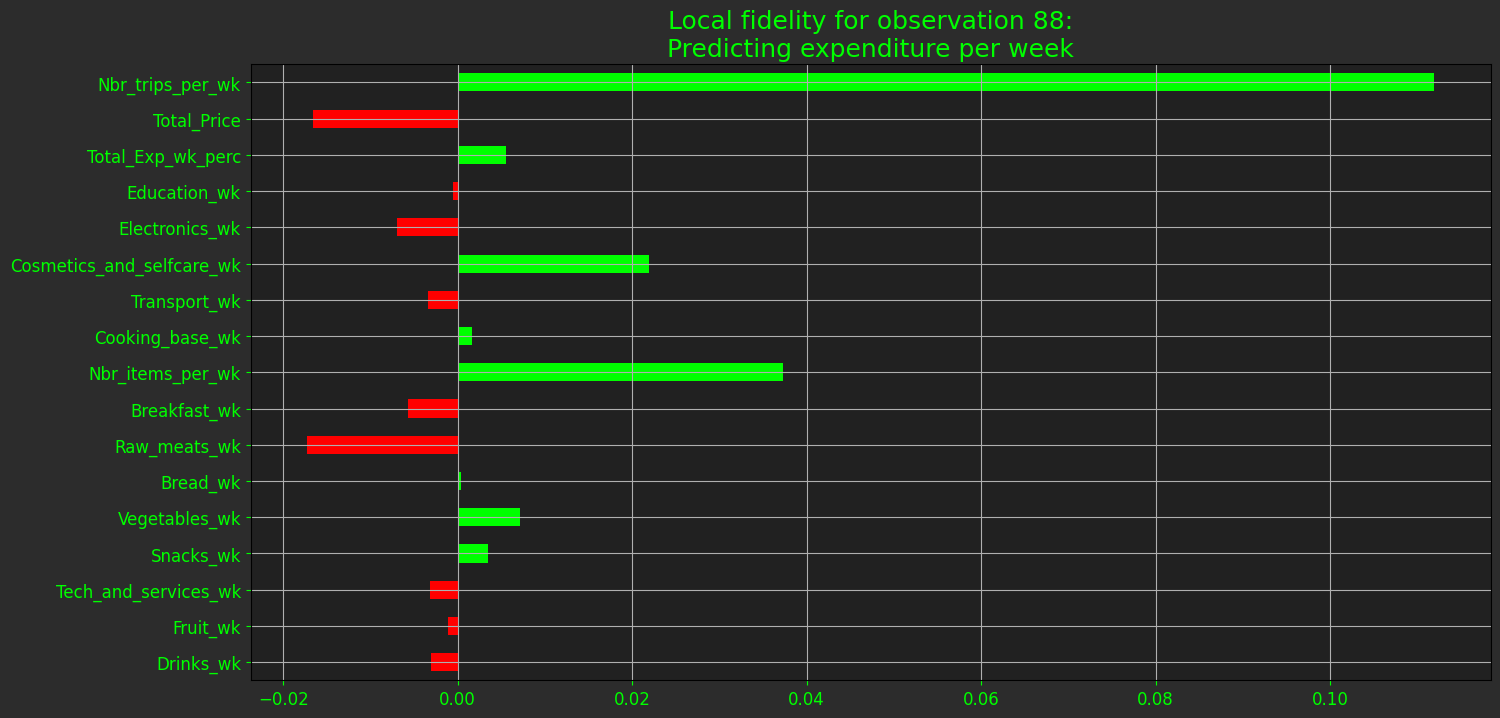

In [24]:
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

pos_val = test_shap_88 > 0

test_shap_88.plot(ax=ax,
                kind='barh',
                color= pos_val.map({True:'lime', False: 'red'}),
                fontsize=12
               )
plt.grid()
plt.title('Local fidelity for observation 88:\nPredicting expenditure per week', fontsize=18)
plt.show()

<p>
The chart above shows the extent of the contribution each feature makes to the estimation of prediction_shap_88.<br>For this instance it can be seen that Nbr_trips_per_wk had a large positive effect on the prediction. Note about<br> half the features have a negative effect on the prediction for this instance. There are also other relatively large positive contributions, green bars; whereas the red bars are relatively smaller.
This would result in a larger prediction for expenditure per week.
Below the model is used to predict test88_data and inverse transformed the prediction to see the actual predicted expenditure. Given the large positive contributions, the prediction is expected to be large.
</p>

<h3 style="color: green;">Predicting observation 88 to confirm the fidelity/explaination</h3>

In [27]:
test88_data = X_test.loc[88:88,:]

# predicting Expenditure per week with the sample above
test_88_pred = GBR.predict(test88_data)


actual_88_pred = y_scaler.inverse_transform(test_88_pred.reshape(-1,1))

print(f"Standardized output: {test_88_pred[0]} \nInverse transformed output: {actual_88_pred[0][0]}")

Standardized output: -0.013349396417908034 
Inverse transformed output: 119.8799999677547


<p>
The prediction of £119.88 is much higher than the prediction for test10_data. This validates the explaination for the prediction of test88_data.
</p>

<h3 style="color: green;">Local fidelity for observation 139</h3>

In [28]:
test_shap_139 = pd.Series(X_test_shap_values[139,:], index=X_test.iloc[139,:].index)
test_shap_139

Drinks_wk                    0.005757
Fruit_wk                     0.006610
Tech_and_services_wk         0.034348
Snacks_wk                   -0.005573
Vegetables_wk               -0.005293
Bread_wk                    -0.036363
Raw_meats_wk                -0.015460
Breakfast_wk                -0.004457
Nbr_items_per_wk             0.023708
Cooking_base_wk             -0.005319
Transport_wk                -0.001574
Cosmetics_and_selfcare_wk    0.005504
Electronics_wk              -0.004642
Education_wk                -0.000089
Total_Exp_wk_perc           -0.013391
Total_Price                 -0.010838
Nbr_trips_per_wk            -0.050681
dtype: float64

<h3 style="color: green;">Calculating the prediction shap value for observation 139</h3>


In [30]:
prediction_shap_139 = test_shap_139.sum() + explainer.expected_value
prediction_shap_139[0]

-0.22256755061986716

<h3 style="color: green;">Plotting local fidelity for observation 139</h3>

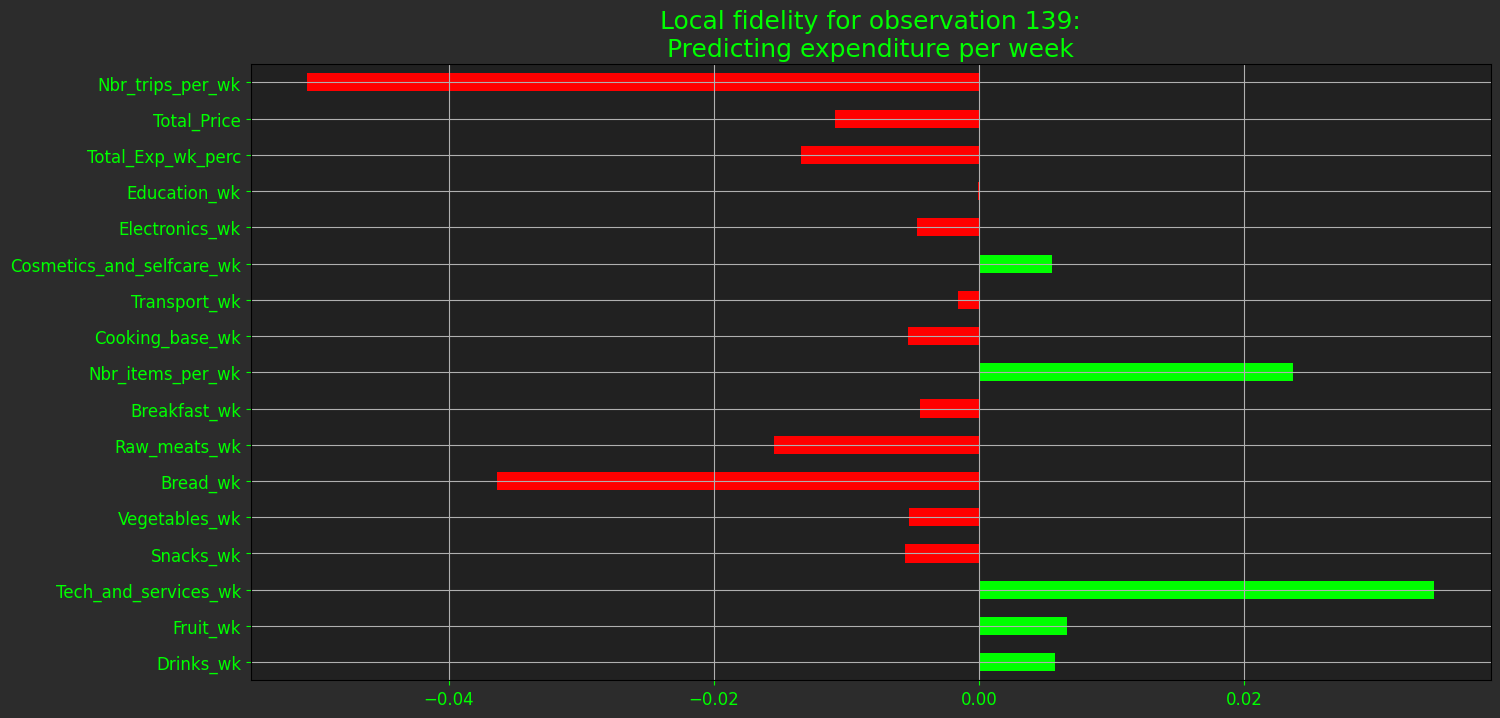

In [31]:
fig,ax = plt.subplots(figsize=(16,8))
fig.patch.set_facecolor('#212121')
fig.patch.set_alpha(0.95)

ax.patch.set_facecolor('#212121')
ax.patch.set_alpha(1.0)
ax.yaxis.label.set_color('lime')
ax.xaxis.label.set_color('lime')
ax.title.set_color('lime')
ax.tick_params(colors='lime', which='both')

pos_val = test_shap_139 > 0

test_shap_139.plot(ax=ax,
                kind='barh',
                color= pos_val.map({True:'lime', False: 'red'}),
                fontsize=12
               )
plt.grid()
plt.title('Local fidelity for observation 139:\nPredicting expenditure per week', fontsize=18)
plt.show()

<p>
The chart above illustrates the middle ground between observation 10 and observation 88. There are significant<br> large negative effects, Nbr_trips_per_wk, Bread_wk; and there are moderate positive effects;<br> Tech_and_services_wk, Nbr_items_per_wk, Fruit_wk, Cosmetics_and_selfcare_wk. These negative and positive effects<br>are somewhat balanced out. So it is expected that observation 139 prediction will be between £39.64 and £119.88
</p>

In [34]:
test139_data = X_test.loc[139:139,:]

# predicting Expenditure per week with the sample above
test_139_pred = GBR.predict(test139_data)


actual_139_pred = y_scaler.inverse_transform(test_139_pred.reshape(-1,1))

print(f"Standardized output: {test_139_pred[0]} \nInverse transformed output: {actual_139_pred[0][0]}")

Standardized output: -0.22256755061986566 
Inverse transformed output: 64.99779957165201


<p>
As anticipated, the prediction £65.00 for observation 139 lies between £39.64 and £119.88, confirming the explaination.
</p>

<h1 style="color: green;">Summary</h1>
<p>
Above, the model output have been explained using global fidelity and local fidelity.<br>
How the features account for the shifts that result in the prediction output have all been visualized.<br><br>
Machine learning models are complexed. Explainable AI tools such as SHAP values are effective in visualizing<br>
the contribution of each feature in generating the prediction. If prediction contributing factors can be understood<br>it makes it easier for non technical individuals to trust the model outputs.<br><br>
</p>

<h1 style="color: green;">Final remarks on local fidelity of<br>the classifier and regressor models</h1>
<p>
The classifier and regressor models are reciprocal complements:<br>
In minimizing the number of trips per week expenditure per week is also minimized.<br>

As a result, the local fidelity explainations are opposites:<br>

Visualizing observations where the classifier indicates to less than 5 shopping trips per week will result in<br>
the domination of positive feature contributions, green, for the local fidelity while for the equivalent<br> observation the regressor model will predict a lower value for expenditure per week and the local fidelity will <br>result in the domination of negative feature contributions, red. See classifier and regressor local fidelity<br>for observation 10. Equally, the opposit is the case for observation 88.<br><br>

Note however, the middle ground is expected to be a close tie see<br>
classifier and regressor local fidelity for observation 139.
<p>

